<a href="https://colab.research.google.com/github/UzunDemir/Chest_X-Ray_Classification/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers


In [3]:
from google.colab import files
uploaded = files.upload()


Saving archive (2).zip to archive (2).zip


In [4]:
!unzip 'archive (2).zip'


Archive:  archive (2).zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-00003b.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00012.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00022.jpg  
  inflating: Covid19-dataset/

In [13]:
# Размер изображений
IMG_SIZE = 256
# Путь к директории с тренировочными данными
train_dir = '/content/Covid19-dataset/train'
# Путь к директории с тестовыми данными
test_dir = '/content/Covid19-dataset/test'

# Списки для хранения тренировочных изображений и их меток
X_train = []
y_train = []

# Проход по каждой папке в тренировочной директории
for folder in os.scandir(train_dir):
    count = 0  # Инициализация счетчика изображений в папке
    for entry in os.scandir(train_dir + '/' + folder.name):
        img = cv2.imread(train_dir + '/' + folder.name + '/' + entry.name, cv2.IMREAD_COLOR)  # # Считывание изображения с помощью OpenCV
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Изменение размера изображения до указанного
        img = np.array(img, dtype='float32')  # Преобразование изображения в тип данных float32
        img = img/255  # # Нормализация значений пикселей (деление на 255), то есть приведение в [0, 1]

        X_train.append(img)  # Добавление изображения в список тренировочных данных

        count += 1  # Увеличение счетчика изображений

        # Присваивание метки классу
        if folder.name == 'Covid':
            y_train.append(0)  # Метка 0 для Covid
        elif folder.name == 'Viral Pneumonia':
            y_train.append(1)  # Метка 1 для 'Viral Pneumonia'
        else:
            y_train.append(2)  # Метка 3 для 'Normal'


    print(f"Folder: {folder.name}, Total Training Images: {count}") # Вывод количества изображений в каждой папке

# Преобразование списков в массивы numpy для дальнейшей работы
X_train = np.array(X_train)
y_train = np.array(y_train)

# Списки для хранения аугментированных данных и их меток
X_aug = []
y_aug = []

datagen = ImageDataGenerator(horizontal_flip=True)  # Создание объекта ImageDataGenerator с аугментацией (горизонтальный переворот)

# Генерация аугментированных данных
augmented_data = datagen.flow(X_train, y_train, batch_size=32, shuffle=False)

# Объединение оригинальных данных с аугментированными изображениями и метками
X_aug = np.concatenate([X_train, augmented_data[0][0]], axis=0)  # Объединение изображений
y_aug = np.concatenate([y_train, augmented_data[0][1]], axis=0)  # Объединение меток


Folder: Covid, Total Training Images: 111
Folder: Normal, Total Training Images: 70
Folder: Viral Pneumonia, Total Training Images: 70


In [14]:
# Разделение данных на обучающий и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train, random_state=123)

# Определение модели CNN
model = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Компиляция модели с выбором оптимизатора и функции потерь
opt = optimizers.Adam(learning_rate=0.0001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Контроль сохранения лучшей модели
checkpointer = ModelCheckpoint(filepath="main.h5", verbose=1, save_best_only=True)

# Обучение модели с использованием аугментированных данных и валидации
history = model.fit(X_aug, y_aug, epochs=100, validation_data=(X_val, y_val), batch_size=32, shuffle=True, callbacks=[checkpointer])


Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.5018
Epoch 1: val_loss improved from inf to 1.06906, saving model to main.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 54s 6s/step - loss: 1.0610 - accuracy: 0.5018 - val_loss: 1.0691 - val_accuracy: 0.4474
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.9553 - accuracy: 0.5088
Epoch 2: val_loss improved from 1.06906 to 1.00319, saving model to main.h5
9/9 [==============================] - 59s 7s/step - loss: 0.9553 - accuracy: 0.5088 - val_loss: 1.0032 - val_accuracy: 0.4737
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.8154 - accuracy: 0.5936
Epoch 3: val_loss improved from 1.00319 to 0.86725, saving model to main.h5
9/9 [==============================] - 55s 6s/step - loss: 0.8154 - accuracy: 0.5936 - val_loss: 0.8673 - val_accuracy: 0.7105
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.7562
Epoch 4: val_loss improved from 0.86725 to 0.64438, saving model to main.h5
9/9 [==============================] - 56s 6s/step - loss: 0.6095 - accuracy: 0.7562 - val_loss: 0.6444 - val_ac

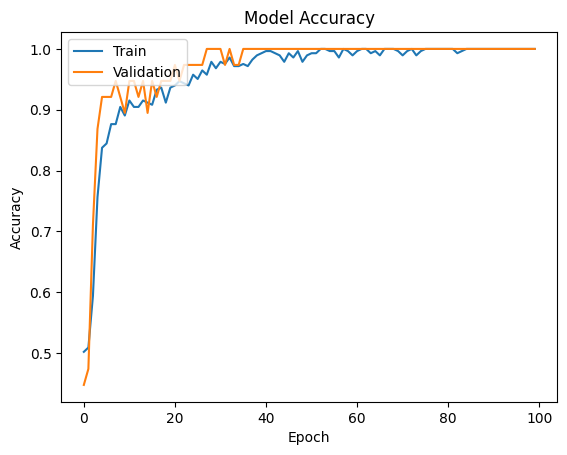

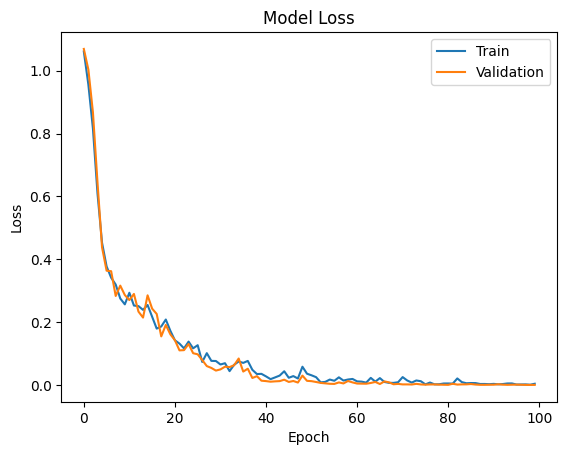

In [15]:
import matplotlib.pyplot as plt
# График обучения и точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# График обучения и потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
# Загрузка и обработка тестовых данных
X_test = []
y_test = []

for folder in os.scandir(test_dir):
    for entry in os.scandir(test_dir + '/' +folder.name):
        img = cv2.imread(test_dir + '/' + folder.name + '/' + entry.name, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.array(img, dtype='float32')
        img = img / 255

        X_test.append(img)

        if folder.name == 'Covid':
            y_test.append(0)
        elif folder.name == 'Viral Pneumonia':
            y_test.append(1)
        else:
            y_test.append(2)

X_test = np.array(X_test)
y_test = np.array(y_test)

model.load_weights("main.h5")

# Оценка модели на тестовых данных
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


3/3 [==============================] - 3s 722ms/step - loss: 0.2924 - accuracy: 0.8636
Test Loss:  0.29238075017929077
Test Accuracy:  0.8636363744735718


In [18]:
from sklearn.metrics import classification_report
# Генерация отчета о классификации
y_pred = model.predict(X_test) # Предсказание классов для тестовых данных
y_pred_classes = np.argmax(y_pred, axis=1) # Получение индексов предсказанных классов
class_names = ['Covid', 'Viral Pneumonia', 'Normal']
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

3/3 [==============================] - 7s 2s/step
                 precision    recall  f1-score   support

          Covid       1.00      0.92      0.96        26
Viral Pneumonia       0.83      0.75      0.79        20
         Normal       0.75      0.90      0.82        20

       accuracy                           0.86        66
      macro avg       0.86      0.86      0.86        66
   weighted avg       0.87      0.86      0.87        66



### Выводы:

1. **Precision (точность)**:
   - Для класса **Covid** точность составляет 1.00, что означает, что модель правильно классифицирует все случаи Covid среди всех предсказанных как Covid случаев на 92%.
   - Для класса **Viral Pneumonia** точность составляет 0.83, что указывает на то, что 83% из всех предсказанных моделью как Viral Pneumonia действительно являются Viral Pneumonia.
   - Для класса **Normal** точность составляет 0.75, что означает, что 75% из всех предсказанных как Normal действительно являются Normal.

2. **Recall (полнота)**:
   - Для класса **Covid** полнота составляет 0.92, что означает, что модель корректно определила 92% всех реальных случаев Covid.
   - Для класса **Viral Pneumonia** полнота составляет 0.75, что указывает на то, что модель идентифицировала 75% всех реальных случаев Viral Pneumonia.
   - Для класса **Normal** полнота составляет 0.90, что означает, что модель обнаружила 90% всех реальных случаев Normal.

3. **F1-score**:
   - Для класса **Covid** F1-score составляет 0.96, что является гармоническим средним между точностью и полнотой.
   - Для класса **Viral Pneumonia** F1-score составляет 0.79, отражая сбалансированное значение точности и полноты.
   - Для класса **Normal** F1-score составляет 0.82, указывая на хороший баланс между точностью и полнотой.

4. **Accuracy (точность)**:
   - Общая точность модели на тестовом наборе данных составляет 0.86, что является процентом правильно классифицированных случаев от общего числа тестовых данных.

5. **Выводы**:
   - Модель демонстрирует высокую точность в классификации класса Covid, что может быть критически важно для медицинских приложений.
   - Важно заметить, что классы Viral Pneumonia и Normal имеют ниже средние значения метрик, что может потребовать дополнительных усилий для улучшения моделирования или изменения пороговых значений классификации в зависимости от конкретных требований задачи.



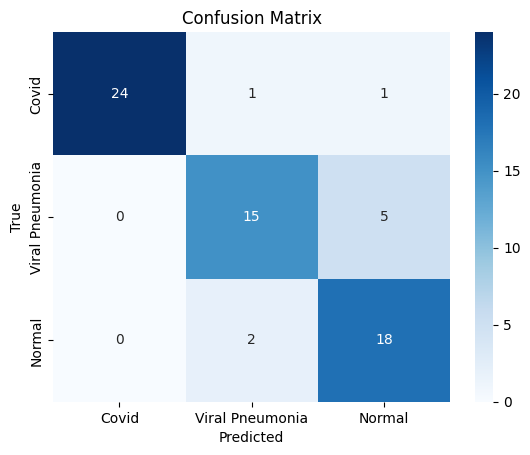

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

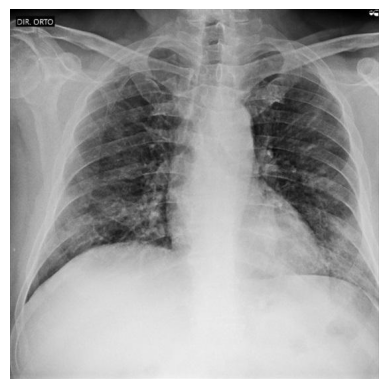

1/1 [==============================] - 0s 87ms/step
True Class: Covid
Predicted Class: Covid


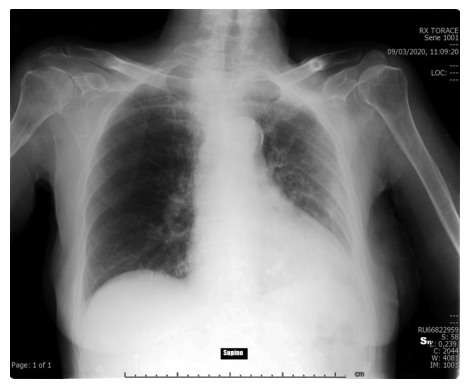

1/1 [==============================] - 0s 91ms/step
True Class: Covid
Predicted Class: Viral Pneumonia


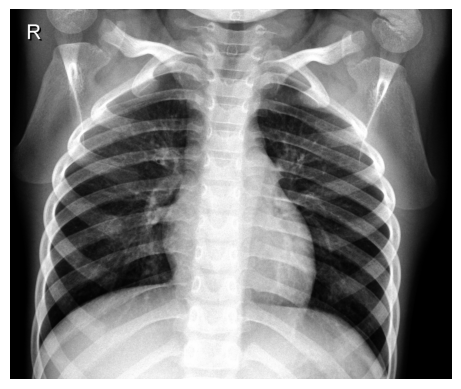

1/1 [==============================] - 0s 112ms/step
True Class: Normal
Predicted Class: Normal


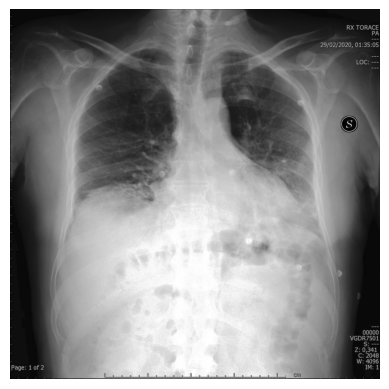

1/1 [==============================] - 0s 101ms/step
True Class: Covid
Predicted Class: Covid


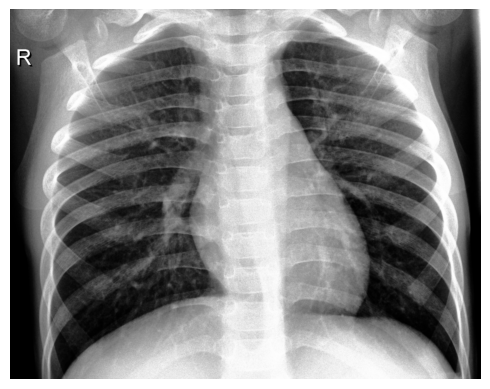

1/1 [==============================] - 0s 96ms/step
True Class: Normal
Predicted Class: Normal


In [24]:
import random

# test directory path and class names
class_names = ['Covid', 'Viral Pneumonia', 'Normal']

# случайно выбираем пять изображений для тестирования
for i in range(5):
    folder_name = random.choice(['Covid', 'Viral Pneumonia', 'Normal'])
    image_name = random.choice(os.listdir(test_dir + '/' + folder_name))
    image_path = os.path.join(test_dir, folder_name, image_name)

    # загружаем и выводим изображение
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # препроцессинг изображения для предсказания
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.array(image, dtype='float32')
    image = image / 255
    image = np.expand_dims(image, axis=0)

    # делаем предсказание
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class_index[0]]

    # выводим предсказание и метку
    print('True Class:', folder_name)
    print('Predicted Class:', predicted_class_name)

TensorFlow Lite Converter (tf.lite.TFLiteConverter) для преобразования модели Keras (model) в формат TensorFlow Lite (tflite). TensorFlow Lite — это инструмент, который позволяет оптимизировать и запускать модели машинного обучения на мобильных и встраиваемых устройствах с ограниченными ресурсами.

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the tflite model to a file
with open('main.tflite', 'wb') as f:
    f.write(tflite_model)